# Data Preprocessing

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms.functional import invert

import numpy as np
import sklearn.cluster as cluster

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [ ]:
!pip install -qq torchmetrics[image] 

from torchmetrics.image.fid import FrechetInceptionDistance

In [ ]:
!pip install -qq wandb
import wandb
wandb.login()

In [4]:
# getting 100k cartoon faces dataset
!gsutil cp gs://cartoonset_public_files/cartoonset100k.tgz .
!tar -xzf cartoonset100k.tgz
!rm cartoonset100k/*.csv
!mkdir images
!mv cartoonset100k images/cartoonset100k

Copying gs://cartoonset_public_files/cartoonset100k.tgz...
\ [1 files][  4.4 GiB/  4.4 GiB]   63.7 MiB/s                                   
Operation completed over 1 objects/4.4 GiB.                                      
rm: cannot remove 'cartoonset100k/*.csv': No such file or directory


In [5]:
!mkdir checkpoints

In [6]:
transform = torchvision.transforms.Compose([
    T.ToTensor(),
    T.Resize(64),
    T.Normalize(mean=[0.9245, 0.8849, 0.8546], std=[0.1938, 0.2409, 0.2864]),
])
dataset = torchvision.datasets.ImageFolder('images/cartoonset100k', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

In [7]:
len(dataset)

100000

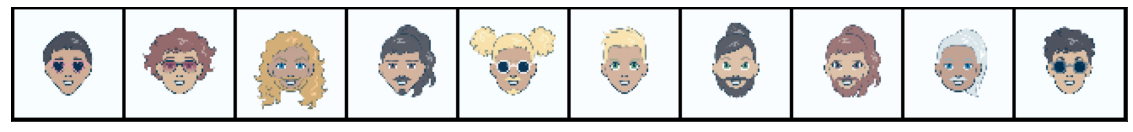

In [8]:
img_batch, _ = next(iter(dataloader))

num_imgs = 10

imgs = torchvision.utils.make_grid(img_batch[:num_imgs], nrow=num_imgs, normalize=True, scale_each=True)

fig, axs = plt.subplots(figsize=(2 * num_imgs, 4))

imgs = T.functional.to_pil_image(imgs)
axs.imshow(np.asarray(imgs))
axs.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [9]:
# code for statistics calculation

@torch.inference_mode()
def calc_statistics(dataloader, total):
    mean = torch.zeros(3)
    second_moment = torch.zeros(3)
    for obj, _ in tqdm(dataloader):
        bsize = obj.shape[0]
        mean += bsize * obj.mean(dim=(0,2,3)) / total
        second_moment += bsize * (obj**2).mean(dim=(0,2,3)) / total
        print(second_moment, mean**2, torch.sqrt(second_moment - mean**2))

    return mean, torch.sqrt(second_moment - mean**2)

# calc_statistics(dataloader, len(dataset))

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
# input noise dimension
nz = 100
# number of generator/discriminator max filters
c_img = 64
# number of channels
nc = 3

# Models

<p align="center">
  <img src="https://github.com/DimaLishudi/GGDR/blob/main/model3-1.png?raw=1" width="500"/>
</p>

Model is based on heavily reworked https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/

In [12]:
class DownBlock(nn.Module):
    '''
        Encoder block, includes pooling (for shape reduction) and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, bias=False, kernel_size=4, activation=nn.LeakyReLU(0.2), bn=True):
        super().__init__()
        
        self.layers = nn.Sequential(
            nn.Conv2d(input_ch, output_ch, kernel_size, stride=2, padding=(kernel_size-1)//2, bias=bias),
            nn.BatchNorm2d(output_ch) if bn else nn.Identity(),
            activation
        )

    def forward(self, x): 
        x = self.layers(x)
        return x


class UpBlock(nn.Module):
    '''
        Decoder block, includes upsampling and Convolutional Block (ConvBlock)
    '''
    def __init__(self, input_ch, output_ch, kernel_size=4, bias=True, activation=nn.LeakyReLU(0.2)):
        super().__init__()
        pad = (kernel_size-1) // 2
        out_pad = kernel_size % 2
    
        self.block = nn.Sequential(
            nn.ConvTranspose2d(input_ch, output_ch, kernel_size, stride=2, padding=pad, output_padding=out_pad, bias=bias),
            nn.BatchNorm2d(output_ch),
            activation
        )


    def forward(self, x):
        '''
            copied_input - feature map from one of the encoder layers
            lower_input - feature map from previous decoder layer
        '''
        return self.block(x)

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.start = nn.Sequential(
            nn.ConvTranspose2d(nz, c_img * 8, 4),
            nn.BatchNorm2d(c_img * 8),
            nn.ReLU(),
        )
        # (c_img*8) x 4 x 4
        self.blocks = nn.ModuleList([
            UpBlock(c_img*8, c_img*4),  # (c_img*4) x 8 x 8
            UpBlock(c_img*4, c_img*2),  # (c_img*2) x 16 x 16
            UpBlock(c_img*2, c_img  ),  # (c_img)   x 32 x 32
        ])

        self.head = nn.Sequential(
            nn.ConvTranspose2d(c_img, nc, 4, stride=2, padding=1),
        )
        # (nc) x 64 x 64 (into [-1, 1])

    def forward(self, input):
        fmaps = []
        out = self.start(input)

        for block in self.blocks:
            out = block(out)
            fmaps.append(out)
        out = self.head(out)
        return out, fmaps


class Discriminator(nn.Module):
    def __init__(self, decoder_ks=None, decoder_activation=nn.Identity, **kwargs):
        super(Discriminator, self).__init__()
        # input is (nc) x 64 x 64
        self.encoder_blocks = nn.ModuleList([
            DownBlock(nc, c_img, bn=False), # (c_img) x 32 x 32
            DownBlock(c_img  , c_img*2),  # (c_img*2) x 16 x 16
            DownBlock(c_img*2, c_img*4),  # (c_img*4) x 8 x 8
            DownBlock(c_img*4, c_img*8)   # (c_img*8) x 4 x 4
        ])

        if decoder_ks is not None:
            self.decoder_blocks = nn.ModuleList([
                UpBlock(c_img*8, c_img*4, decoder_ks, activation=decoder_activation(**kwargs)),  # (c_img*4) x 8 x 8
                UpBlock(c_img*8, c_img*2, decoder_ks, activation=decoder_activation(**kwargs)),  # (c_img*2) x 16 x 16
                UpBlock(c_img*4, c_img,   decoder_ks, activation=decoder_activation(**kwargs)),  # (c_img)   x 32 x 32
            ])
        else:
            self.decoder_blocks = None
        self.head = nn.Sequential(
            nn.Conv2d(c_img * 8, 1, 4),
            nn.Flatten()
        )


    def forward(self, input, return_all_fmaps=False):
        enc_fmaps = []
        dec_fmaps = []
        out = input

        for block in self.encoder_blocks:
            out = block(out)
            enc_fmaps.append(out)

        
        out = self.head(out)

        if self.decoder_blocks is None:
            return out, enc_fmaps

        for i, block in enumerate(self.decoder_blocks):
            if i == 0:
                x = enc_fmaps[-(i+1)]
            else:
                x = torch.cat([enc_fmaps[-(i+1)], dec_fmaps[-1]], dim=1)
            dec_fmaps.append(block(x))
        if return_all_fmaps:
            return out, enc_fmaps, dec_fmaps
        return out, dec_fmaps

We'll try different kernel sizes and activation functions for our decoder.

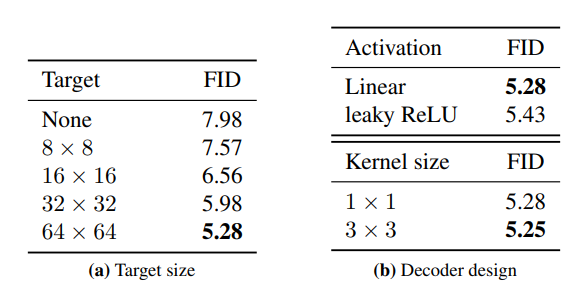

# Training and Support functions

In [14]:
def get_colors():
    dummy_color = np.array([
        [178, 34, 34],   # firebrick
        [0, 139, 139],   # dark cyan
        [245, 222, 179], # wheat
        [25, 25, 112],   # midnight blue
        [255, 140, 0],   # dark orange
        [128, 128, 0],   # olive
        [50, 50, 50],    # dark grey
        [34, 139, 34],   # forest green
        [100, 149, 237], # corn flower blue
        [153, 50, 204],  # dark orchid
        [240, 128, 128], # light coral
    ])

    for t in (0.6, 0.3):  # just increase the number of colors for big K
        dummy_color = np.concatenate((dummy_color, dummy_color * t))

    # dummy_color = (np.array(dummy_color) - 128.0) / 128.0
    # dummy_color = torch.from_numpy(dummy_color)

    return (dummy_color - 128.0) / 128.0


def show_imgs(imgs, nrows=1):
    '''
        imgs - torch.tensor or np.ndarray [B x C x H x W], where C = 3 or 1
        nrows - number of picture rows
    '''

    if isinstance(imgs, torch.Tensor):
        imgs = imgs.detach().cpu().numpy()
    elif not isinstance(imgs, np.ndarray):
        raise TypeError('Expected torch.Tensor or numpy.ndarray')

    # normalization ============================================================

    imgs_min = imgs.min(axis=(1,2), keepdims=True)
    imgs_max = imgs.max(axis=(1,2), keepdims=True)
    imgs = (imgs - imgs_min) / (imgs_max - imgs_min)
    imgs = imgs.transpose(0, 2, 3, 1)

    # plotting =================================================================

    b_size = imgs.shape[0]
    ncols = ceil(b_size / nrows)
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*nrows, 8*ncols))
    
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        return

    axs = axs.flatten()
    for i in range(b_size):
        axs[i].imshow(imgs[i])
        axs[i].axis('off')


def get_fmaps(fmaps, n_clusters=6):
    '''
        fmaps - torch.tensor[B x C x H x W]
        
        returns:
            imgs : numpy.ndarray[B x 3 x H x W]
    '''
    # clusterization ===========================================================

    fmaps = fmaps.detach().cpu().numpy()
    b_size, c_num, h, w = fmaps.shape
    fmaps = fmaps.transpose(0, 2, 3, 1).reshape(b_size, h*w, c_num)
    clusterized = np.empty((b_size, h*w))
    for i in range(b_size):
        clusterized[i] = cluster.KMeans(n_clusters).fit_predict(fmaps[i])

    # substitute clusters with colors ==========================================

    cond = clusterized[:,:,None] == np.arange(n_clusters, dtype=int)[None,None,:]
    idxs = np.nonzero(cond)[-1].reshape(b_size, h, w)
    imgs = get_colors()[idxs]
    
    return imgs.transpose(0, 3, 1, 2)


def get_byte_imgs(img_batch, clip=False):
    '''
        Independenty scales img_batch : torch.Tensor[B, C, H, W] and transforms into
        dint8 images in range [0, 255]
    '''
    if clip:
        img_batch = img_batch.clip(-1, 1)
    batch_max = torch.amax(img_batch, dim=[2,3], keepdim=True)
    batch_min = torch.amin(img_batch, dim=[2,3], keepdim=True)
    scaled_batch = (img_batch - batch_min) / (batch_max - batch_min)
    return (scaled_batch * 255).byte()

  
@torch.inference_mode()
def get_pics_fmaps(G, D, real_batch):
    '''
        Args:
            G -- Generator model
            D -- Discriminator model
            real batch: torch.Tensor[B x H x W] -- batch of real images
            run_decoder: bool -- whether to run decoder part of D for feature maps,
                                 set to True if D was trained with GGDR
        Returns:
            real_images, generated_images -- torch tensors returned by make_grid.
            real_images consists of B real images an B corresponding feature maps of D
            generated_images consists of B generetaed images, B corresponding feature maps of G and
            B corresponding feature maps of D
    '''
    bs, _, H, W = real_batch.shape
    resizer = nn.Upsample((H,W))

    ggdr = D.decoder_blocks is not None

    # real_images ==============================================================
    cat_imgs = real_batch

    if ggdr:
        out, enc_fmaps, dec_fmaps = D(real_batch, return_all_fmaps=True)
        for fmap_idx in range(FMAP_IDX, 3+1):
            enc_fmap = enc_fmaps[fmap_idx-1]
            dec_fmap = dec_fmaps[-fmap_idx]

            cat_imgs = torch.cat([
                cat_imgs,
                resizer(torch.from_numpy(get_fmaps(enc_fmap)).to(device)),
                resizer(torch.from_numpy(get_fmaps(dec_fmap)).to(device)),
            ], dim=0)
    else:
        out, enc_fmaps = D(real_batch)
        for fmap_idx in range(FMAP_IDX, 3+1):
            enc_fmap = enc_fmaps[fmap_idx-1]
            cat_imgs = torch.cat([
                cat_imgs,
                resizer(torch.from_numpy(get_fmaps(enc_fmap)).to(device)),
            ], dim=0)
    real_images = torchvision.utils.make_grid(cat_imgs, nrow=bs, normalize=True, scale_each=True)

    # generated_images =========================================================

    noise = torch.randn(bs, nz, 1, 1, device=device)
    generated, G_fmaps = G(noise)
    cat_imgs = generated

    if ggdr:
        out, enc_fmaps, dec_fmaps = D(generated, return_all_fmaps=True)
        for fmap_idx in range(FMAP_IDX, 3+1):
            g_fmap = G_fmaps[-fmap_idx]
            enc_fmap = enc_fmaps[fmap_idx-1]
            dec_fmap = dec_fmaps[-fmap_idx]

            cat_imgs = torch.cat([
                cat_imgs,
                resizer(torch.from_numpy(get_fmaps(g_fmap)).to(device)),
                resizer(torch.from_numpy(get_fmaps(enc_fmap)).to(device)),
                resizer(torch.from_numpy(get_fmaps(dec_fmap)).to(device)),
            ], dim=0)
    else:
        out, enc_fmaps = D(generated)
        for fmap_idx in range(FMAP_IDX, 3+1):
            g_fmap = G_fmaps[-fmap_idx]
            enc_fmap = enc_fmaps[fmap_idx-1]
            cat_imgs = torch.cat([
                cat_imgs,
                resizer(torch.from_numpy(get_fmaps(g_fmap)).to(device)),
                resizer(torch.from_numpy(get_fmaps(enc_fmap)).to(device)),
            ], dim=0)

    generated_images = torchvision.utils.make_grid(cat_imgs, nrow=bs, normalize=True, scale_each=True)

    return real_images, generated_images

In [15]:
# noise = torch.randn(1, nz, 1, 1, device=device)
# G_out, _ = G(noise)
# G_out.to('cpu')
# torch.amax(G_out, dim=[2, 3])

In [16]:
# cur_logs = {}
# log_batch_size = 20
# real_batch = next(iter(dataloader))[0][:log_batch_size].to(device)
# real_imgs, gen_imgs = get_pics_fmaps(G, D, real_batch, clip=False)
    
# real_images = wandb.Image(
#     real_imgs,
#     caption=f'Top: Real Images\nBottom: Discriminator Feature Maps'
# )
# generated_images = wandb.Image(
#     gen_imgs,
#     caption=f'Top: Generated Images\nMiddle: Generator Feature Maps\nBottom: Discriminator Feature Maps'
# )
# cur_logs['Real'] = real_images
# cur_logs['Genereated'] = generated_images
# wandb.log(cur_logs)

In [24]:
FMAP_IDX = 1 # 1 for 32 x 32, 2 for 16 x 16, 3 for 8 x 8

def get_losses(G, D, G_opt, D_opt, real_batch, regcoef=None):
    bs = real_batch.shape[0]
    bce = torch.nn.BCEWithLogitsLoss()

    noise = torch.randn(bs, nz, 1, 1, device=device)
    G_out, G_fmaps = G(noise)
    D_out, D_fmaps = D(G_out.detach())

    D_real_loss = bce(D(real_batch)[0].view(-1), torch.ones(bs, device=device))
    D_gen_loss = bce(D_out.view(-1), torch.zeros(bs, device=device))
    D_loss = D_real_loss + D_gen_loss

    cosine_dist = None
    if regcoef is not None:
        cosine_dist = 1 - F.cosine_similarity(G_fmaps[-FMAP_IDX].detach(), D_fmaps[-FMAP_IDX]).mean()
        D_loss += regcoef * cosine_dist

    D_opt.zero_grad()
    D_loss.backward()
    nn.utils.clip_grad_value_(D.parameters(), clip_value=5.0)
    D_opt.step()

    D_out, D_fmaps = D(G_out)
    G_loss = bce(D_out.view(-1), torch.ones(bs, device=device))

    G_opt.zero_grad()
    G_loss.backward()    
    nn.utils.clip_grad_value_(G.parameters(), clip_value=5.0)
    G_opt.step()

    return G_loss, D_loss, G_out, D_real_loss, D_gen_loss, cosine_dist



def train_one_epoch(G, D, G_opt, D_opt, dataloader, FID=None, img_log_step=10000, log_batch_size=20, regcoef=None):
    G.train()
    D.train()
    cur_step = 0
    
    for real_batch, _ in tqdm(dataloader):
        real_batch = real_batch.to(device)
        cur_step += real_batch.shape[0]

        # get losset, optimizer steps
        G_loss, D_loss, G_out, D_real_loss, D_gen_loss, cosine_dist = get_losses(G, D, G_opt, D_opt, real_batch, regcoef)
        
        # logging

        if FID is not None:
            imgs = get_byte_imgs(G_out).to(device)
            FID.update(imgs, real=False)
  
        cur_logs = {
            'D loss' : D_loss.cpu().item(),
            'D real loss' : D_real_loss.cpu().item(),
            'D gen loss' : D_gen_loss.cpu().item(),
            'G loss' : G_loss.cpu().item(),
        }
        if cosine_dist is not None:
            cur_logs['cosine dist'] = cosine_dist.cpu().item()

        if cur_step >= img_log_step:
            cur_step = cur_step % img_log_step
            
            real_batch = next(iter(dataloader))[0][:log_batch_size].to(device)
            real_imgs, gen_imgs = get_pics_fmaps(G, D, real_batch)
                
            real_images = wandb.Image(
                real_imgs,
                caption=f'Top: Real Images; Then Dicriminator Encoder FMaps, Discriminator Decoder FMaps for each Resolution'
            )
            generated_images = wandb.Image(
                gen_imgs,
                caption=f'Top: Generated Images; Then Generator FMaps, Dicriminator Encoder FMaps, Discriminator Decoder FMaps for each Resolution'
            )
            cur_logs['Real'] = real_images
            cur_logs['Genereated'] = generated_images
        wandb.log(cur_logs)


def train(G, D, G_opt, D_opt, dataloader, epochs=4, FID=None, calculate_FID=False, img_log_step=10000, log_batch_size=20, regcoef=None, name='default'):

    if calculate_FID and FID is None:
        FID = FrechetInceptionDistance(reset_real_features=False).to(device)

        # First we need to give FID module full real dataset for calculation
        for real_batch, _ in tqdm(dataloader):
            imgs = get_byte_imgs(real_batch).to(device)
            FID.update(imgs, real=True)
    if calculate_FID:
        FID.to(device)
        FID.reset()
    
    # training loop
    for epoch in range(epochs):
        print(f'Starting training epoch {epoch+1}/{epochs}\n')
        logs = {'epoch' : epoch + 1}
        if calculate_FID:
            train_auroc = train_one_epoch(G, D, G_opt, D_opt, dataloader, FID, img_log_step, log_batch_size, regcoef)
            logs['FID'] = FID.compute.item()
            FID.reset()
        else:
            train_auroc = train_one_epoch(G, D, G_opt, D_opt, dataloader, None, img_log_step, log_batch_size, regcoef)

        wandb.log(logs)
        checkpoints = {
            'G' : G.state_dict(),
            'D' : D.state_dict(),
        }
        torch.save(checkpoints, f'checkpoints/{name}/GD_{epoch+1}.pt')
    return FID

In [ ]:
name = '32x32_Linear_BigLambda'
wandb.init(project='GGDR', name=name)
dir_name = 'checkpoints/' + name

In [19]:
!mkdir $dir_name

# Training

Do note, that FID computation on 100k images takes rougly the same time as 1 training epoch -- 10 minutes on colab.

It may be wise to calculate FID only after training is complete.



In [ ]:
# FID = FrechetInceptionDistance(reset_real_features=False).to(device)

# # First we need to give FID module full real dataset for calculation
# # it takes around 10 minutes in colab, so you should not recalculate it each epoch

# for real_batch, _ in tqdm(dataloader):
#     imgs = get_byte_imgs(real_batch).to(device)
#     FID.update(imgs, real=True)

In [26]:
G = Generator().to(device)
D = Discriminator(decoder_ks=3).to(device)

G_opt = torch.optim.Adam(G.parameters(), lr=3e-4, betas=(0.5, 0.999))
D_opt = torch.optim.Adam(D.parameters(), lr=3e-4, betas=(0.5, 0.999))

In [ ]:
train(G, D, G_opt, D_opt, dataloader, epochs=3, regcoef=50, name=name)

In [61]:
def calculate_fid(G, FID):
    FID.reset()
    G.eval()
    step = 100
    with torch.inference_mode():
      for i in tqdm(range(0, len(dataset), step)):
          noise = torch.randn(step, nz, 1, 1, device=device)
          G_out, _ = G(noise)
          imgs = get_byte_imgs(G_out).to(device)
          FID.update(imgs, real=False)
    return FID.compute()

In [ ]:
fid = calculate_fid(G, FID)
wandb.log({'FID': fid.item()})

In [ ]:
wandb.finish()

# Comparing Discriminator Optimizations

In [ ]:
!pip install -qq thop
from thop import profile
from copy import deepcopy

In [30]:
class PureDecoder(nn.Module):
    def __init__(self, decoder_ks, num_blocks=3, activation=nn.Identity, **kwargs):
        super().__init__()
        
        modules = []
        channel = c_img*8

        for i in range(num_blocks):
            modules.append(
                UpBlock(channel, channel//4, decoder_ks, activation=activation(**kwargs)),  # (c_img*4) x 8 x 8
            )
            channel = channel//2

        self.decoder_blocks = nn.Sequential(*modules)

    def forward(self, input):
        fmaps = []

        for i, block in enumerate(self.decoder_blocks):
            if i == 0:
                x = input
            else:
                x = torch.cat([torch.randn_like(fmaps[-1]), fmaps[-1]], dim=1)
            fmaps.append(block(x))
        return fmaps

In [31]:
def get_flops_params(model, input_size=(3, 64, 64)):
    test_batch_size = 100
    model.to('cpu')
    local_model = deepcopy(model)
    macs, params = profile(local_model, (torch.randn(test_batch_size, *input_size),), verbose=False)
    
    return macs*2, params

In [40]:
flops, params = {}, {}
for px_name, num_blocks in zip(['32px', '64px'], [3, 4]):
    for ks_name, decoder_ks in zip(['1x1', '3x3'], [1, 3]):
        for act_name, activation in zip(['Linear', 'LeakyReLU'], [nn.Identity, nn.LeakyReLU]):
          D = PureDecoder(
              num_blocks=num_blocks,
              decoder_ks=decoder_ks,
              activation=activation,
              negative_slope=0.2
          )
          name = ' '.join([px_name, ks_name, act_name])
          flops[name], params[name] = get_flops_params(D, input_size=(c_img*8, 4,4))

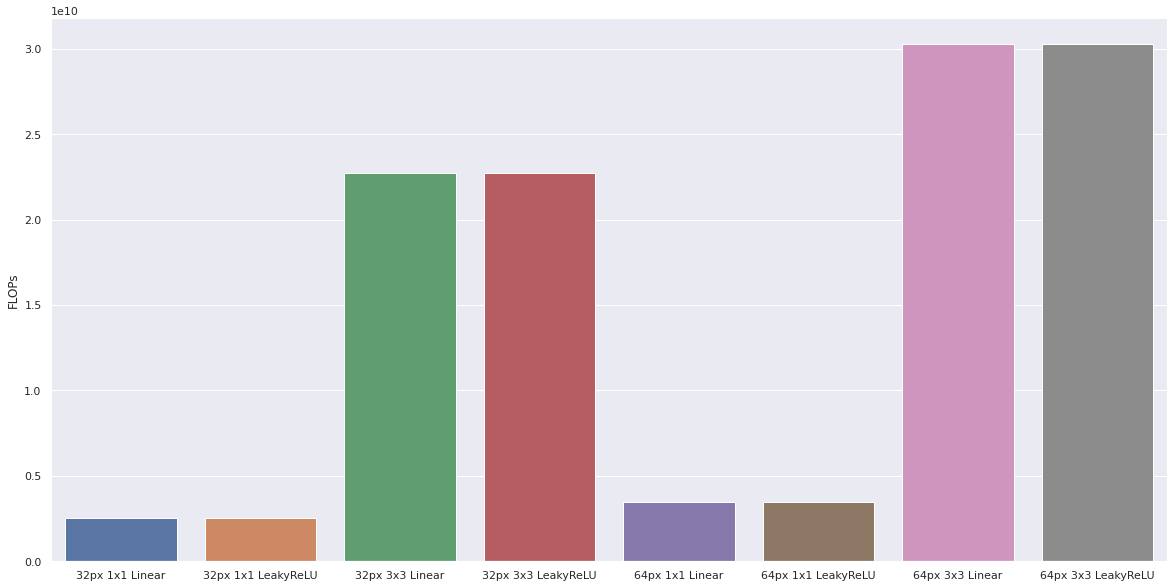

In [41]:
names = list(flops.keys())
flop_arr = [flops[name] for name in names]

sns.set(rc={'figure.figsize':(20,10)})
axs = sns.barplot(x=names, y=flop_arr)
axs.set(ylabel='FLOPs')
plt.savefig('FLOPS.png');

For comparison: StyleGan2 requires $450 \cdot 10^{10}$ FLOPs for batch of 100 images 256 x 256.